## Data and Package Importing

In [396]:
import sys
sys.path.append('../')
from QC_old import *
sc.settings.set_figure_params(dpi=80, frameon=False)

In [397]:
sys.executable

'/home/victoria/anaconda3/envs/LauLab/bin/python'

### Load data and preprocess

In [398]:
%time s1 = sc.read_h5ad('../data/3777-SM-2-CTTGTA_S2.h5ad') # read in one of the annotated example files

CPU times: user 5.67 s, sys: 966 ms, total: 6.64 s
Wall time: 6.68 s


In [399]:
s1 # see contents of AnnData object

AnnData object with n_obs × n_vars = 5754 × 38459 
    obs: 'ken_filter'

Standard preprocessing to get metadata for barcodes:

In [400]:
# checkpoint raw data for future filtering
s1.raw = s1

In [401]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(s1)

# create new "observations" as percent and mean mito genes
s1.var['mito'] = s1.var_names.str.contains('mt-') # identify mitochondrial genes
s1.obs['mean_mito'] = np.mean(s1[:,s1.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(s1, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var

# rank cells by total counts and save as .obs
s1.obs['ranked_total_counts'] = np.argsort(s1.obs['total_counts'])

CPU times: user 3.12 s, sys: 1.77 s, total: 4.89 s
Wall time: 4.91 s


### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [402]:
from skimage.filters import threshold_li, threshold_otsu, threshold_isodata, threshold_mean, threshold_yen, threshold_triangle # popular thresholding methods
from scipy.stats import mode

In [403]:
maxArray = np.array(s1.obs['log1p_total_counts'])

In [404]:
# use both Otsu's and Li's methods on the log-transformed total counts for each barcode:
threshOtsu = threshold_otsu(np.array(s1.obs['log1p_total_counts']))
threshLi = threshold_li(np.array(s1.obs['log1p_total_counts']))
threshIsodata = threshold_isodata(np.array(s1.obs['log1p_total_counts']))
threshMean = threshold_mean(np.array(s1.obs['log1p_total_counts']))
threshYen = threshold_yen(np.array(s1.obs['log1p_total_counts']))
threshTriangle = threshold_triangle(np.array(s1.obs['log1p_total_counts']))
globalMax = mode(maxArray)   #sorta works, returns 5.92, too low

In [405]:
globalMax

ModeResult(mode=array([5.488938], dtype=float32), count=array([34]))

Plot Otsu and Li thresholds on `log1p_total_counts`:

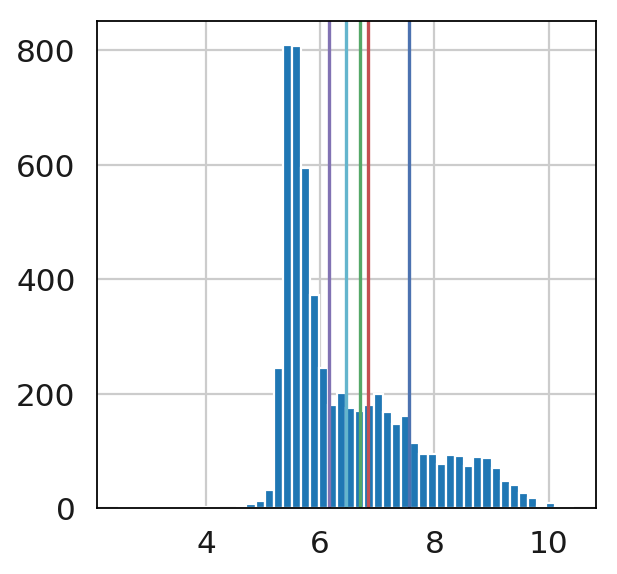

In [406]:
_ = plt.hist(s1.obs['log1p_total_counts'], bins=50)
plt.axvline(threshOtsu, color='r') # otsu threshold
plt.axvline(threshLi, color='g') # li threshold
plt.axvline(threshMean, color='c')
plt.axvline(threshYen, color='b')
plt.axvline(threshTriangle, color='m')

In [407]:
# get subset of array from 0 to where the threshold ends
firstArray = _[0]
secondArray = _[1]
secondArrayEnd = np.where(secondArray <= threshMean)
subFirstArray = firstArray[slice(0, np.amax(secondArrayEnd))]
subSecondArray = secondArray[slice(0, np.amax(secondArrayEnd))]

In [408]:
subSecondArray

array([2.4849067, 2.6438468, 2.8027868, 2.9617267, 3.1206667, 3.2796068,
       3.438547 , 3.5974867, 3.7564268, 3.915367 , 4.074307 , 4.233247 ,
       4.392187 , 4.551127 , 4.710067 , 4.869007 , 5.027947 , 5.186887 ,
       5.345827 , 5.504767 , 5.6637073, 5.822647 , 5.981587 , 6.1405272],
      dtype=float32)

In [409]:
# find the peak of a distribution within the range of 0 and the threshold
maxValue = max(subFirstArray)
maxIndex = np.where(subFirstArray == np.amax(subFirstArray))
realMax = subSecondArray[maxIndex]

In [410]:
realMax

array([5.345827], dtype=float32)

### Find inflection point

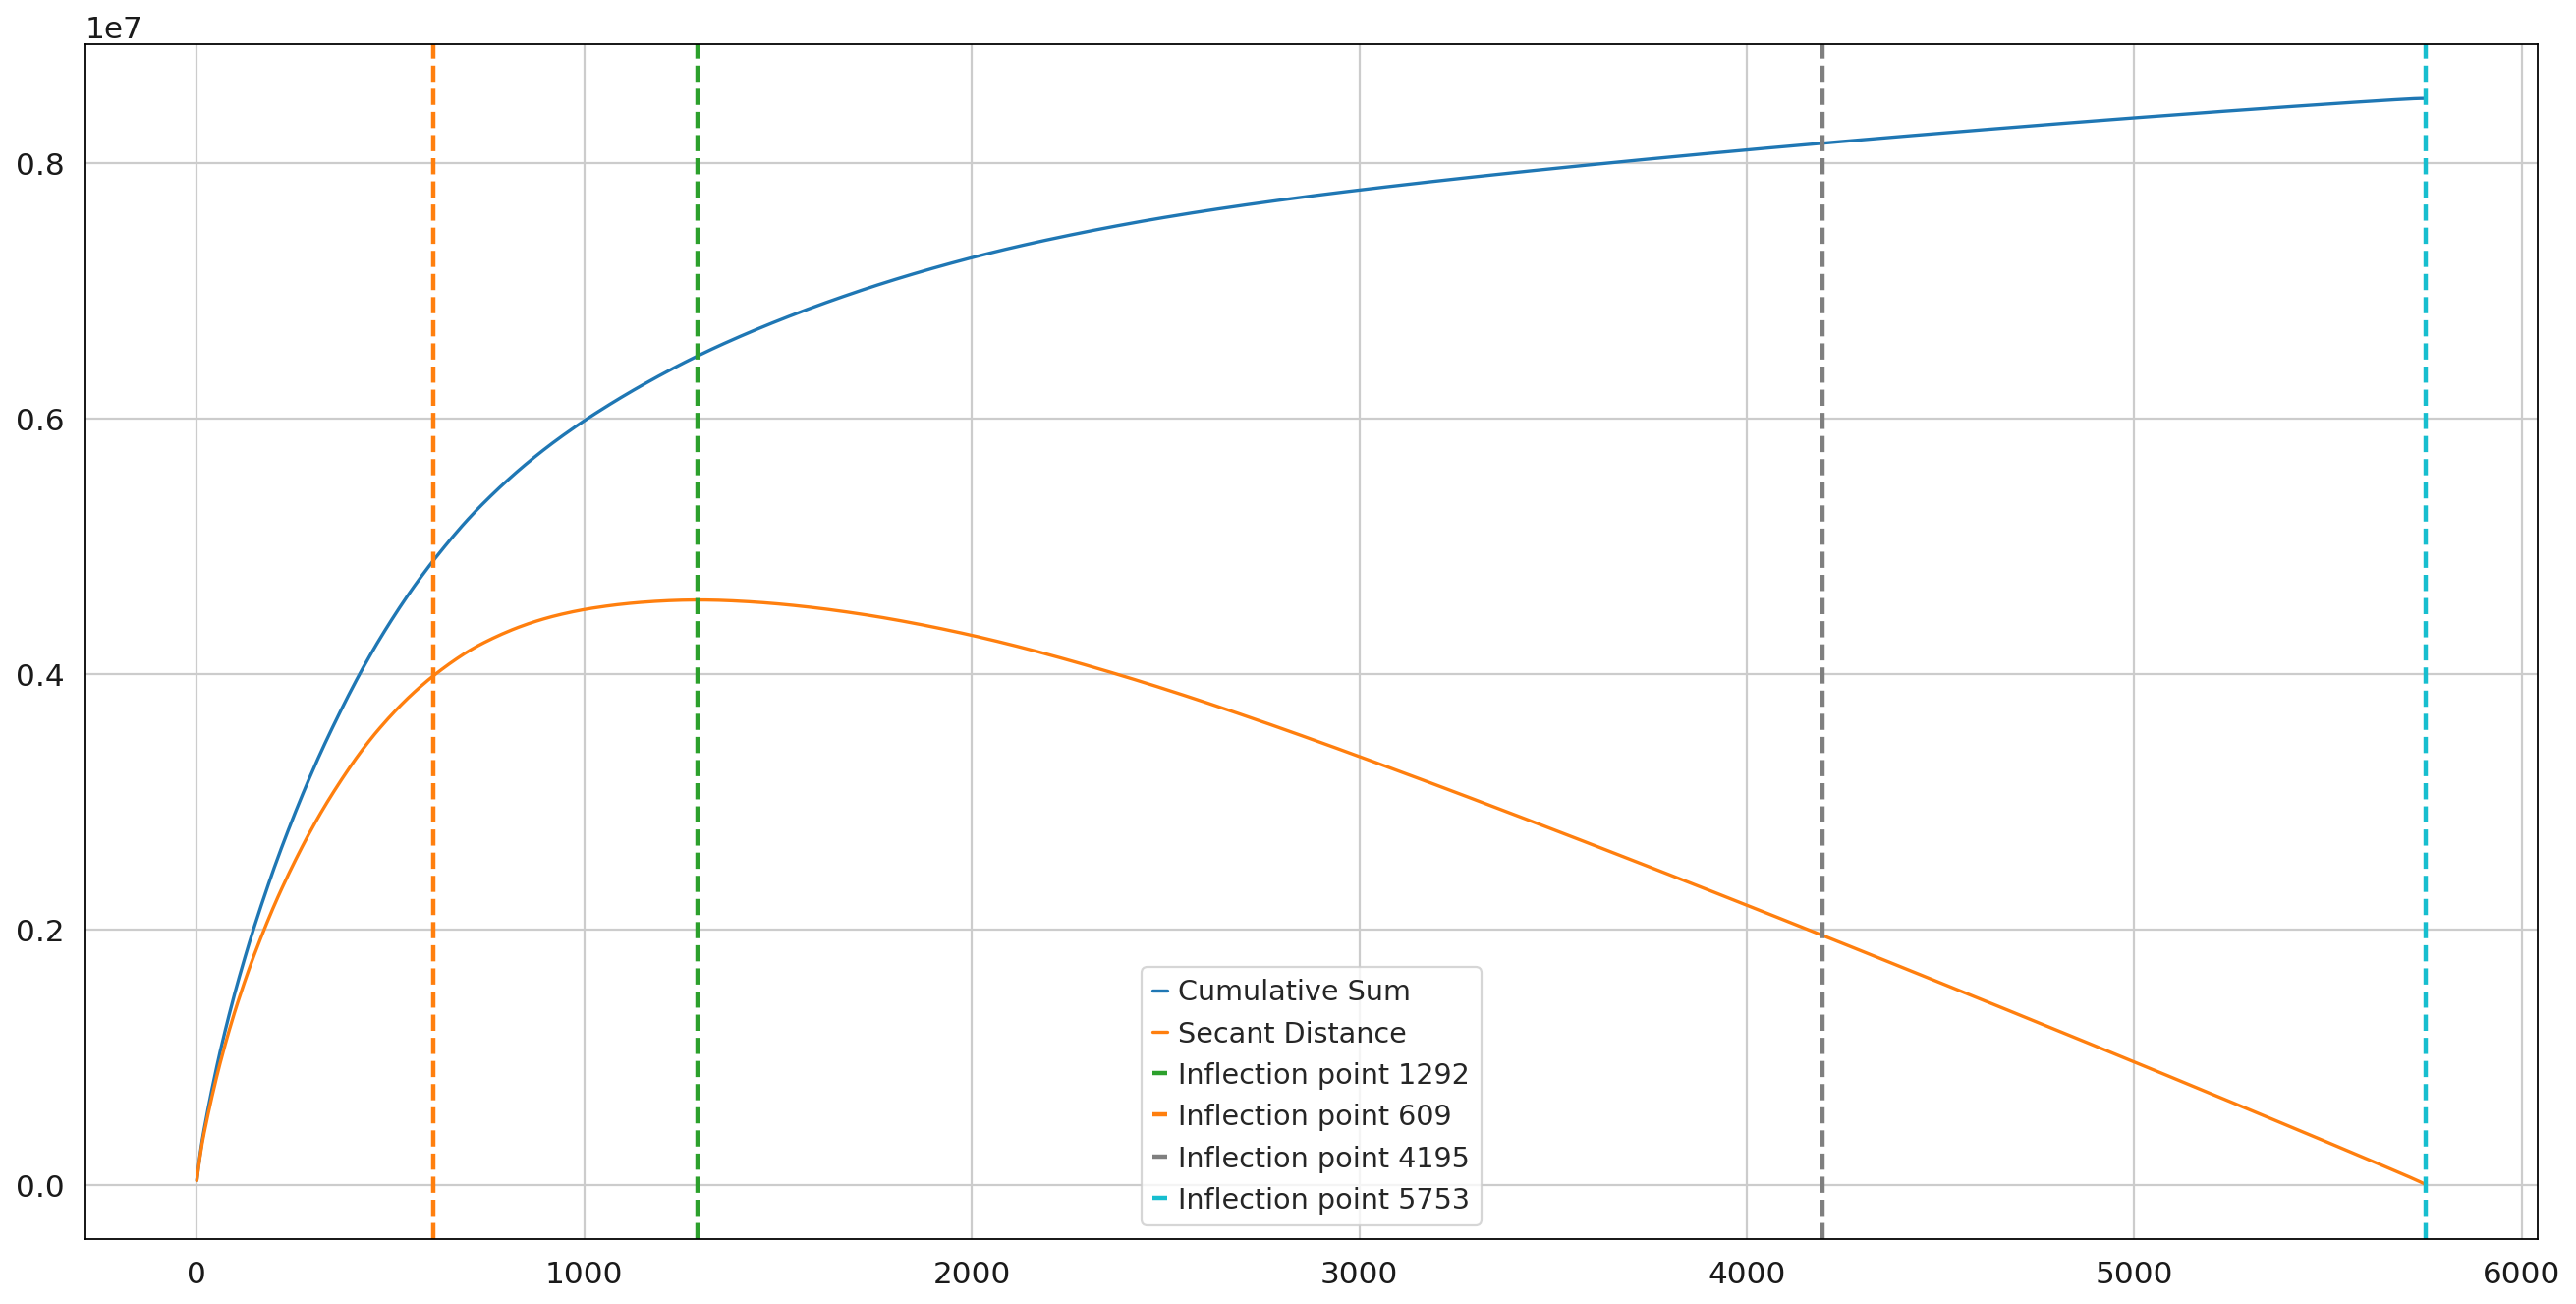

Inflection point at index
3839    1292
4089     609
1817    4195
0       5753
Name: total_counts, dtype: int64 for [0, 31, 70, 100] percentiles of greatest secant distances


{0: 1292, 31: 609, 70: 4195, 100: 5753}

In [411]:
# inflection_percentiles are percentages of maximum secant distance. we wanna pick one to the right of the maximum
find_inflection(s1, inflection_percentiles = [0,31,70,100], output_prefix='')

The purple cutoff looks pretty good if we were manually filtering the data. Let's see how many total counts and log1p-transformed total counts the cell at that position has:

In [412]:
s1.obs['total_counts'][3401] # see the total counts for the cutoff point

319.0

In [413]:
s1.obs['log1p_total_counts'][3401] # see the log-transformed total counts for the cutoff point; this should be close to otsu or li threshold

5.768321

So the above number should correspond to a cutoff between the two 'lumps' in our `log1p_total_counts` distribution, and it looks close to our `Otsu` and `Li` thresholds.  
Let's plot it to compare to the automated thresholds from `skimage`:

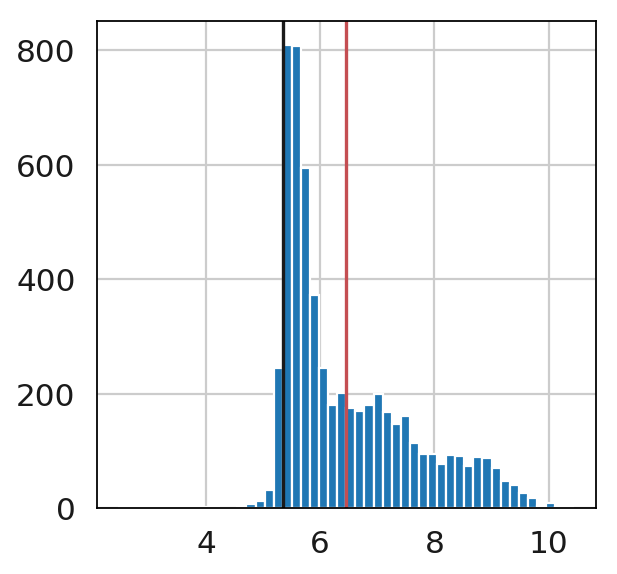

In [414]:
_ = plt.hist(s1.obs['log1p_total_counts'], bins=50)
#plt.axvline(threshOtsu, color='r') # otsu
#plt.axvline(threshLi, color='g') # li
plt.axvline(threshMean, color='r')
#plt.axvline(threshYen, color='b')
#plt.axvline(threshTriangle, color='m')
plt.axvline(realMax[0], color='k')
#plt.axvline(s1.obs['log1p_total_counts'][3401], color='y') # threshold chosen from one of the inflection point percentage cutoffs

In [415]:
realMax[0]

5.345827

In [416]:
np.expm1(realMax[0])

208.73128

In [417]:
#s1.obs.index

In [418]:
expmRealMax = np.expm1(realMax[0])
expmThreshMean = np.expm1(threshMean)

In [419]:
emptyDropsThresh = pd.read_csv("emptyDrops-thresh-3777-S2.csv")

In [420]:
# only use when barcode data type does not match with index data type
emptyDropsThresh.barcode = emptyDropsThresh.barcode.astype(str)

In [421]:
s1.obs = s1.obs.merge(emptyDropsThresh, left_on = 'index', right_on = 'barcode')

AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 


In [422]:
s1.obs.loc[s1.obs["total_counts"] <= expmRealMax, "victoria_filter"] = 0
s1.obs.loc[s1.obs["total_counts"] > expmRealMax, "victoria_filter"] = 1
realMaxIndex = np.where(s1.obs["victoria_filter"] == 0)[0]

In [423]:
s1.obs.loc[s1.obs["total_counts"] <= expmThreshMean, "thresh_mean_filter"] = 0
s1.obs.loc[s1.obs["total_counts"] > expmThreshMean, "thresh_mean_filter"] = 1
threshMeanIndex = np.where(s1.obs["thresh_mean_filter"] == 0)[0]

In [424]:
kenIndex = np.where(s1.obs["ken_filter"] == 0)[0]
emptyDropsIndex = np.where(s1.obs["empty"] == 1)[0]

In [425]:
s1.obs

,ken_filter,mean_mito,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,ranked_total_counts,Total,LogProb,PValue,Limited,FDR,empty,barcode,victoria_filter,thresh_mean_filter
0,1,66.027023,7182,8.879472,33924.0,10.431908,20.988091,28.599222,37.619385,51.173211,...,5753,33924,-28708.137585,0.0001,True,0.0,0,0,1.0,1.0
1,1,86.945946,6016,8.702344,26851.0,10.198095,28.881606,35.588991,43.417377,55.886187,...,5752,26851,-23459.064440,0.0001,True,0.0,0,1,1.0,1.0
2,1,43.270271,6099,8.716044,25590.0,10.149996,19.921844,27.018367,36.291520,50.691676,...,5751,25590,-23374.140686,0.0001,True,0.0,0,2,1.0,1.0
3,1,45.027027,5938,8.689296,24390.0,10.101970,21.775318,28.798688,37.872079,51.779418,...,5750,24390,-22470.990472,0.0001,True,0.0,0,8,1.0,1.0
4,1,35.324326,5646,8.638880,24030.0,10.087100,21.223471,28.942988,38.193924,53.116937,...,5749,24030,-21524.208000,0.0001,True,0.0,0,3,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5749,0,0.027027,15,2.772589,15.0,2.772589,100.000000,100.000000,100.000000,100.000000,...,4,15,NaN,NaN,NaN,NaN,1,4579,0.0,0.0
5750,0,0.027027,11,2.484907,14.0,2.708050,100.000000,100.000000,100.000000,100.000000,...,3,14,NaN,NaN,NaN,NaN,1,5720,0.0,0.0
5751,0,0.000000,12,2.564949,13.0,2.639057,100.000000,100.000000,100.000000,100.000000,...,2,13,NaN,NaN,NaN,NaN,1,5003,0.0,0.0
5752,0,0.000000,12,2.564949,12.0,2.564949,100.000000,100.000000,100.000000,100.000000,...,1,12,NaN,NaN,NaN,NaN,1,4586,0.0,0.0


In [426]:
# A vs. B is equal to the elements present in A but not in B
# B vs. A is equal to the elements present in B but not in A

In [427]:
emptyDropsKenSet = len(set(emptyDropsIndex).difference(set(kenIndex))) # where emptyDrops_index is larger than ken_index
realMaxKenSet = len(set(realMaxIndex).difference(set(kenIndex))) # where real_max_index is larger than ken_index
realMaxEmptyDropsSet = len(set(realMaxIndex).difference(set(emptyDropsIndex))) # where real_max_index is larger than emptyDrops_index
threshMeanKenSet = len(set(threshMeanIndex).difference(set(kenIndex)))
threshMeanEmptyDropsSet = len(set(threshMeanIndex).difference(set(emptyDropsIndex)))

In [428]:
kenEmptyDropsSet = len(set(kenIndex).difference(set(emptyDropsIndex))) # where ken_index is larger than emptyDrops_index
kenRealMaxSet = len(set(kenIndex).difference(set(realMaxIndex))) # where ken_index is larger than real_max
emptyDropsRealMaxSet = len(set(emptyDropsIndex).difference(set(realMaxIndex))) # where emptyDrops_index is larger than real_max_index
kenThreshMeanSet = len(set(kenIndex).difference(set(threshMeanIndex)))
emptyDropsThreshMeanSet = len(set(emptyDropsIndex).difference(set(threshMeanIndex)))

In [429]:
# overlap for empty cells
print("emptyDrops vs. ken: ", emptyDropsKenSet)
print("real max vs. ken: ", realMaxKenSet)
print("real max vs. emptyDrops: ", realMaxEmptyDropsSet)
print("thresh mean vs. ken: ", threshMeanKenSet)
print("thresh mean vs. emptyDrops: ", threshMeanEmptyDropsSet)

emptyDrops vs. ken:  422
real max vs. ken:  10
real max vs. emptyDrops:  0
thresh mean vs. ken:  360
thresh mean vs. emptyDrops:  277


In [430]:
print("ken vs. emptyDrops: ", kenEmptyDropsSet)
print("ken vs. real max: ", kenRealMaxSet)
print("emptyDrops vs. real max: ", emptyDropsRealMaxSet)
print("ken vs. thresh mean: ", kenThreshMeanSet)
print("emptyDrops vs. thresh mean: ", emptyDropsThreshMeanSet)

ken vs. emptyDrops:  285
ken vs. real max:  3120
emptyDrops vs. real max:  3247
ken vs. thresh mean:  267
emptyDrops vs. thresh mean:  321


In [431]:
# Histograms after filtering

In [432]:
s1.obs.index = s1.obs.barcode

In [433]:
s2 = s1.obs.copy()

In [434]:
def emptyLog1pTotalCounts(dataframe, filterMethod, whichColor):
    if (filterMethod == "empty"):
        whichEmpty = 0
    else:
        whichEmpty = 1
    log1pTotalCountsFilter = np.where(dataframe[filterMethod] == whichEmpty)[0]
    subsetLog1pTotalCounts = dataframe.iloc[log1pTotalCountsFilter]["log1p_total_counts"]
    
    _ = plt.hist(subsetLog1pTotalCounts, bins = 50, color = whichColor)
    plt.axvline(realMax[0], color = 'k')
    return (log1pTotalCountsFilter, dataframe[filterMethod] == whichEmpty)

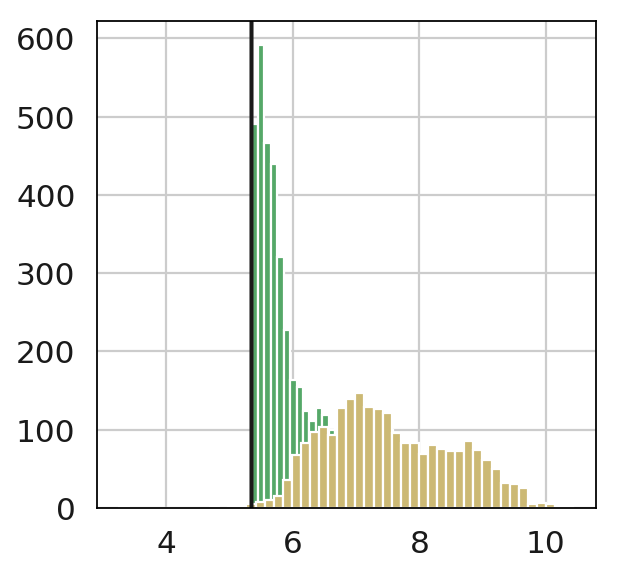

In [435]:
realMaxDataset, realMaxBoolVector = emptyLog1pTotalCounts(s2, "victoria_filter", 'g')
emptyDropsDataset, emptyDropsBoolVector = emptyLog1pTotalCounts(s2, "empty", 'r')
threshMeanDataset, threshMeanBoolVector = emptyLog1pTotalCounts(s2, "thresh_mean_filter", 'b')
kenFilterDataset, kenFilterBoolVector = emptyLog1pTotalCounts(s2, "ken_filter", 'y')

In [436]:
s1.write_h5ad("filtered-3777-S2.h5ad", compression = "gzip")

... storing 'Limited' as categorical


In [ ]:
#s3 = s1[realMaxDataset].copy()

In [ ]:
#s3.write_h5ad("realMaxDataset-2771-S3.h5ad", compression = "gzip")